In [175]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [176]:
import os
import pandas as pd
import numpy as np

In [177]:
# データ保存ディレクトリへ移動
ls = os.getcwd().split('\\')
ls[-1] = 'data'
lsr=""
for i in ls:
    lsr += i+'\\'

# ディレクトリ移動
os.chdir(lsr)

In [178]:
train = pd.read_csv('./datasets_nb001/nb001_train.csv', index_col=0)
test = pd.read_csv('./datasets_nb001/nb001_test.csv', index_col=0)

In [179]:
# 提出データ用に受け皿を作成
PassengerID_df = test.PassengerId

In [180]:
print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'CategoricalAge',
       'SibSp_0_1_2over', 'Parch_0_1_2_3over', 'FamilySize', 'IsAlone',
       'CategoricalFare', 'Title', 'Title_num', 'SexC'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'CategoricalAge',
       'SibSp_0_1_2over', 'Parch_0_1_2_3over', 'FamilySize', 'IsAlone',
       'Title', 'Title_num', 'SexC'],
      dtype='object')


In [181]:
# 不要な列の削除
train.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'CategoricalFare'],
            axis=1, inplace=True)

test.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin'],
            axis=1, inplace=True)

# 欠損データの削除

In [182]:
# Ageに含まれる欠損値の行を削除
X_full = train.dropna(axis=0, subset=['Age'], inplace=False).copy()

# yとXをそれぞれ定義
y = X_full.Survived
X_full.drop(['Survived'], axis=1, inplace=True)

# 話を簡単にするため、object型の列データを除外
X = X_full.select_dtypes(exclude=['object'])

# 交差検証を導入テスト

### n_estimaters = 50

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Pipeline を定義
my_pipeline_50 = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                ('model', RandomForestClassifier(n_estimators=50,
                                                                random_state=0))
                                ])

## フォールド数 = 5 (CVパラメータ)

In [184]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline_50, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [0.23776224 0.17482517 0.14685315 0.25874126 0.14788732]
Average MAE score (across experiments):
0.19321382842509605


## CVを実行した結果群の 平均MAE を取得する関数定義

In [185]:
def get_score(n_estimators):
    """Return the average MAE over 5 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestClassifier(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=5,  # set the number of doing CV
                                  scoring='neg_mean_absolute_error')
    return scores.mean()

## 辞書として結果を取得し、可視化

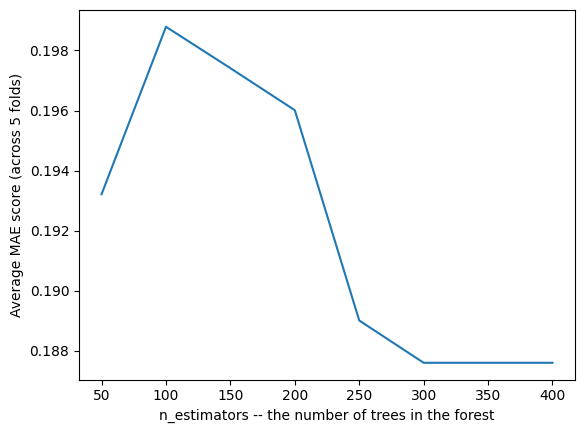

n_estimators_best:  300


In [186]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('n_estimators -- the number of trees in the forest')
plt.ylabel('Average MAE score (across 5 folds)')
plt.show()

# 最良の結果を取得
n_estimators_best = min(results, key=results.get) # 組み込み関数には引数を指定可能
print("n_estimators_best: ", n_estimators_best)

In [187]:
results

{50: 0.19321382842509605,
 100: 0.1987885354082537,
 150: 0.19740963262090022,
 200: 0.19601103122229885,
 250: 0.1890081749236679,
 300: 0.18759972421944254,
 350: 0.18759972421944254,
 400: 0.18759972421944254}

## 提出用モデルを作成

In [188]:
# 定義
my_pipeline_fin = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                ('model', RandomForestClassifier(n_estimators=n_estimators_best,
                                                                random_state=0))
                                ])

In [189]:
# 訓練
my_pipeline_fin.fit(X, y)

Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('model',
                 RandomForestClassifier(n_estimators=300, random_state=0))])

In [190]:
# 訓練データと同様に、object型の列データを除外
X_test = test.select_dtypes(exclude=['object'])

# 推定
y_pred = my_pipeline_fin.predict(X_test)

# Kaggleへ提出

In [191]:
y_pred.shape

(418,)

In [192]:
submission_df = pd.DataFrame()
submission_df['Survived'] = y_pred
submission_df['PassengerID'] = PassengerID_df
submission_df.head(3)

,Survived,PassengerID
0,0,892
1,0,893
2,1,894


In [193]:
# 出力
submission_df = submission_df.set_index('PassengerID')
submission_df.to_csv(r"./submit/nb005_n_estimators_300.csv", encoding='utf-8', index=True)